

**Практика 5: Атака с ограниченной памятью (PGD - Projected Gradient Descent)**

**Выполнил: Очередько Антон Николаевич ББМО-01-23**


Шаг 1: Загрузка обученной модели и данных MNIST

In [11]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в one-hot кодировку
test_labels = to_categorical(test_labels, 10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9740 - loss: 0.0878
Test accuracy on clean images: 0.9768000245094299


Шаг 2-3: Изучение теории и реализация атаки PGD с использованием Foolbox

In [12]:
!pip install foolbox

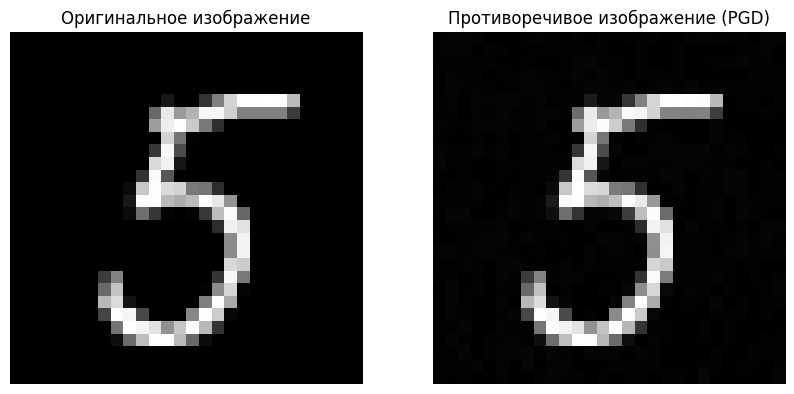

In [13]:
import tensorflow as tf
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt

# Функция для выполнения атаки и вывода результатов
def run_attack(model, test_images, test_labels, image_index=253, epsilon=0.01, attack_steps=10):
    # Инициализация модели Foolbox
    fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

    # Подготовка изображения и метки
    image = tf.convert_to_tensor(test_images[image_index], dtype=tf.float32)[None, ...]
    label = tf.convert_to_tensor(np.argmax(test_labels[image_index]), dtype=tf.int64)

    attack = fb.attacks.LinfPGD(steps=attack_steps)

    # Выполнение атаки
    advs, _, success = attack(fmodel, image, label[None], epsilons=epsilon)

    # Отображение результатов
    display_results(image, advs)

# Функция для отображения исходного и атакованного изображений
def display_results(original_image, adversarial_image):
    plt.figure(figsize=(10, 5))

    # Исходное изображение
    plt.subplot(1, 2, 1)
    plt.title("Оригинальное изображение")
    plt.imshow(original_image[0].numpy(), cmap="gray")
    plt.axis('off')

    # Атакованное изображение
    plt.subplot(1, 2, 2)
    plt.title("Противоречивое изображение (PGD)")
    plt.imshow(adversarial_image[0].numpy(), cmap="gray")
    plt.axis('off')

    plt.show()

# Пример вызова функции с использованием данных
run_attack(model, test_images, test_labels)




Шаг 4: Оценка модели на противоречивых примерах

In [22]:
import tensorflow as tf
import numpy as np
import foolbox as fb
from tqdm import tqdm

# Функция для создания набора противоречивых примеров
def generate_adversarial_examples(model, test_images, test_labels, epsilon=0.1):
    # Инициализация модели Foolbox
    fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

    # Создание объекта атаки (PGD)
    attack = fb.attacks.LinfPGD(steps=10)

    adversarial_images = []

    for i in tqdm(range(len(test_images)), desc="Generating adversarial examples"):
        # Подготовка изображения и метки
        image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
        label = tf.convert_to_tensor(np.argmax(test_labels[i]), dtype=tf.int64)

        # Выполнение атаки
        advs, _, success = attack(fmodel, image, label[None], epsilons=epsilon)
        adversarial_images.append(advs)

    return tf.concat(adversarial_images, axis=0)

adversarial_images = generate_adversarial_examples(model, test_images, test_labels)

adversarial_acc = evaluate_adversarial_accuracy(model, adversarial_images, test_labels)

# Вывод результатов
print(f'Accuracy on adversarial examples (PGD): {adversarial_acc}')

Generating adversarial examples: 100%|██████████| 10000/10000 [19:07<00:00,  8.71it/s]


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4604 - loss: 1.9838
Accuracy on adversarial examples (PGD): 0.5123999714851379


Шаг 5:

Вывод:
Результаты показывают, что модель теряет в точности после применения атаки PGD. Точность на атакованных примерах составила 51.24%. Это говорит о том, что модель уязвима к такой атаке, и даже небольшие изменения в изображениях могут сильно повлиять на её работу.







